<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/ML%20-%20Transformer%20-%20overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация временных рядов при помощи архитектуры Transformer

https://repod.icm.edu.pl/dataset.xhtml?persistentId=doi:10.18150/repod.0107441

Проведем бинарную классификацию данных ЭЭГ больных шизофренией.

In [ ]:
! pip install mne

In [ ]:
from glob import glob
import os
import mne
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#read all file
all_files_path=glob('*.edf')
print(len(all_files_path))

28


In [ ]:
all_files_path[0]

's06.edf'

In [ ]:
healthy_file_path=[i for i in all_files_path if  'h' in i]
patient_file_path=[i for i in all_files_path if  's' in i]

In [ ]:
def read_data(file_path):
    datax=mne.io.read_raw_edf(file_path,preload=True)
    datax.set_eeg_reference()
    datax.filter(l_freq=1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(datax,duration=25,overlap=0)
    epochs=epochs.get_data()
    return epochs #trials,channel,length

In [ ]:
data=read_data(healthy_file_path[0])

Extracting EDF parameters from /content/h12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 224999  =      0.000 ...   899.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [ ]:
data.shape

(36, 19, 6250)

In [ ]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [ ]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

14 14


In [ ]:
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))

28 28


In [ ]:
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [ ]:
features_array=np.vstack(data_list)
df_Y_array=np.hstack(label_list)
df_group_array=np.hstack(groups_list)
#features_array=np.moveaxis(features_array,1,2)


In [ ]:
features_array.shape, df_Y_array.shape, df_group_array.shape

((1142, 19, 6250), (1142,), (1142,))

Для кодирования временной последовательности возьмем готовый PositionalEncoding из документации и посмотрим, как он сможет справиться с данными ЭЭГ

https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Сам трансформер

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=3, hidden_dim=128, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x.shape: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, hidden_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim) for transformer
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, hidden_dim)
        x = x.mean(dim=0)  # Aggregate sequence dimension
        x = self.fc(x)  # (batch_size, num_classes)
        return x


In [ ]:
#обучение
def train_classifier(model, train_loader, val_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        correct_train_preds += (predicted == y).sum().item()
        total_train_preds += y.size(0)

    # Compute validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            loss = loss_fn(output, y)
            val_loss += loss.item()

    train_accuracy = correct_train_preds / total_train_preds
    return train_loss / len(train_loader), val_loss / len(val_loader), train_accuracy

In [ ]:
def evaluate_classifier(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            output = model(x)
            preds = torch.argmax(output, dim=1)
            all_preds.append(preds)
            all_labels.append(y)
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    accuracy = accuracy_score(labels.numpy(), preds.numpy())
    return accuracy

In [ ]:
# графики

def plot_stats(train_loss, val_loss, train_accuracy, valid_accuracy, title):
    plt.figure(figsize=(16, 8))
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(16, 8))
    plt.title(title + ' accuracy')
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Validation accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def train_and_evaluate_classifier(df_all_clean_array, df_Y_array, df_group_array, num_classes):
    input_dim = df_all_clean_array.shape[2]
    seq_len = df_all_clean_array.shape[1]

    gkf = GroupKFold()

    accuracy_train = []
    accuracy_test = []

    for train_index, val_index in gkf.split(df_all_clean_array, df_Y_array, groups=df_group_array):
        train_features, train_labels = df_all_clean_array[train_index], df_Y_array[train_index]
        val_features, val_labels = df_all_clean_array[val_index], df_Y_array[val_index]

        train_accuracy_history = []
        valid_accuracy_history = []

        train_loss_history = []
        val_loss_history = []

        # Применяем StandardScaler ко всем временным шагам
        scaler = StandardScaler()
        # Объединяем batch и time для стандартизации
        train_features_reshaped = train_features.reshape(-1, train_features.shape[2])
        val_features_reshaped = val_features.reshape(-1, val_features.shape[2])

        train_features_scaled = scaler.fit_transform(train_features_reshaped).reshape(train_features.shape)
        val_features_scaled = scaler.transform(val_features_reshaped).reshape(val_features.shape)

        # Преобразуем в тензоры
        train_features_tensor = torch.tensor(train_features_scaled, dtype=torch.float32)  # (batch_size, seq_len, input_dim)
        val_features_tensor = torch.tensor(val_features_scaled, dtype=torch.float32)      # (batch_size, seq_len, input_dim)
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
        val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

        # Создаем DataLoader
        train_loader = DataLoader(TensorDataset(train_features_tensor, train_labels_tensor), batch_size=128, shuffle=True)
        val_loader = DataLoader(TensorDataset(val_features_tensor, val_labels_tensor), batch_size=128, shuffle=False)

        # Инициализируем модель
        model = TransformerClassifier(input_dim, num_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Тренировка модели
        for epoch in range(10):
            train_loss, val_loss, train_accuracy = train_classifier(model, train_loader, val_loader, optimizer, loss_fn)
            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_accuracy_history.append(train_accuracy)
            val_accuracy = evaluate_classifier(model, val_loader)
            valid_accuracy_history.append(val_accuracy)
            print(f'Epoch {epoch}: Train loss {train_loss}, Val loss {val_loss}, Train accuracy {train_accuracy}, Val accuracy {val_accuracy}')

        accuracy_train.append(evaluate_classifier(model, train_loader))
        accuracy_test.append(val_accuracy)

        plot_stats(train_loss_history, val_loss_history, train_accuracy_history, valid_accuracy_history, 'Transformer model')

    return accuracy_train, accuracy_test

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0: Train loss 0.8340059295296669, Val loss 0.7531857490539551, Train accuracy 0.5323819978046103, Val accuracy 0.3722943722943723
Epoch 1: Train loss 0.6595972329378128, Val loss 0.7651336789131165, Train accuracy 0.5927552140504939, Val accuracy 0.3722943722943723
Epoch 2: Train loss 0.5754495784640312, Val loss 0.728866845369339, Train accuracy 0.6234906695938529, Val accuracy 0.39826839826839827
Epoch 3: Train loss 0.36809543520212173, Val loss 1.1151212602853775, Train accuracy 0.9187705817782656, Val accuracy 0.5151515151515151
Epoch 4: Train loss 0.08753743255510926, Val loss 2.1951232254505157, Train accuracy 0.973655323819978, Val accuracy 0.44155844155844154
Epoch 5: Train loss 0.046893719874788076, Val loss 2.619523048400879, Train accuracy 0.9857299670691547, Val accuracy 0.47619047619047616
Epoch 6: Train loss 0.048917265492491424, Val loss 3.0299190282821655, Train accuracy 0.986827661909989, Val accuracy 0.4329004329004329
Epoch 7: Train loss 0.09422499989159405, Va

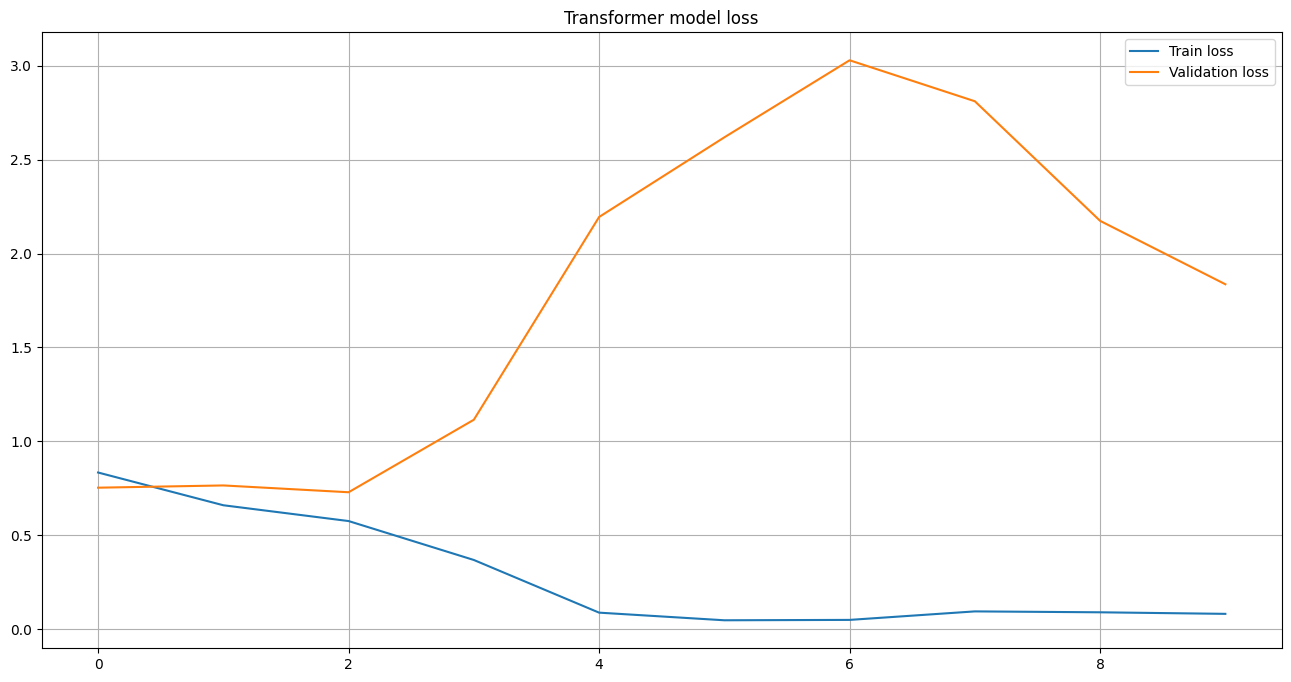

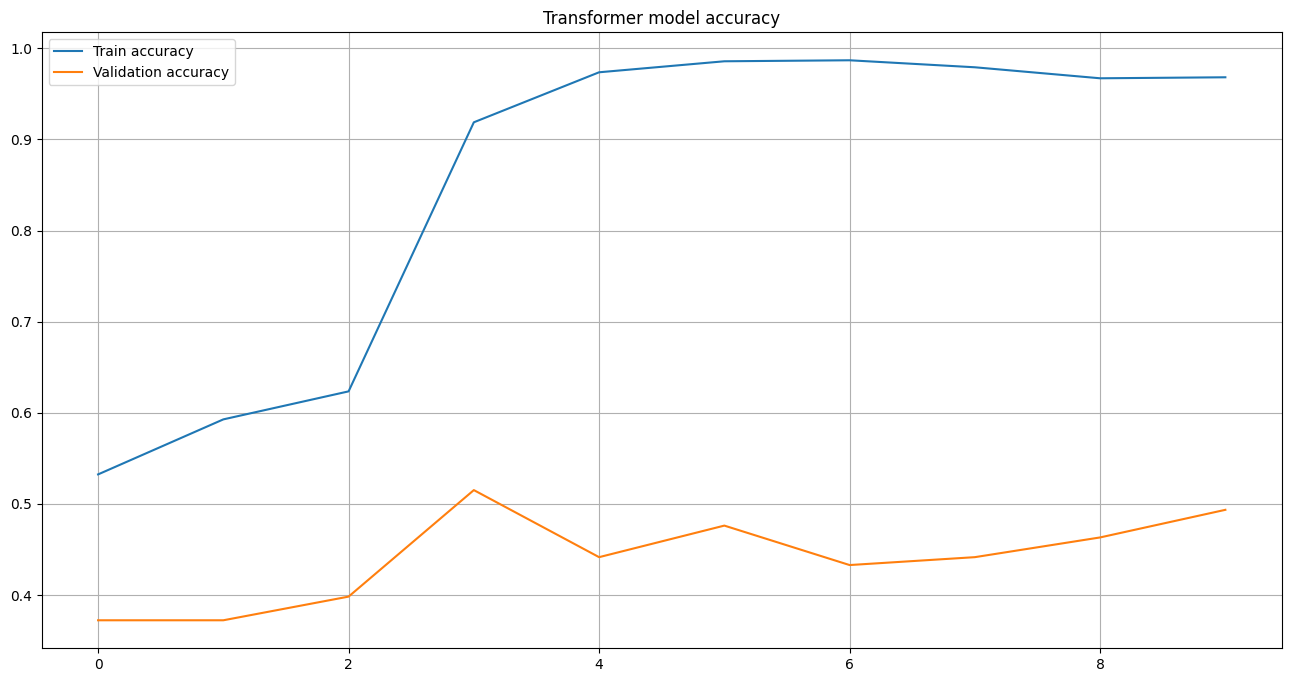

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0: Train loss 0.8508153781294823, Val loss 0.7469189465045929, Train accuracy 0.4732905982905983, Val accuracy 0.39805825242718446
Epoch 1: Train loss 0.6337848380208015, Val loss 0.6033322662115097, Train accuracy 0.6303418803418803, Val accuracy 0.6359223300970874
Epoch 2: Train loss 0.4975873492658138, Val loss 0.7296054363250732, Train accuracy 0.7510683760683761, Val accuracy 0.5242718446601942
Epoch 3: Train loss 0.2077291663736105, Val loss 1.2281922101974487, Train accuracy 0.9433760683760684, Val accuracy 0.5436893203883495
Epoch 4: Train loss 0.03785980539396405, Val loss 2.1363391280174255, Train accuracy 0.9925213675213675, Val accuracy 0.49029126213592233
Epoch 5: Train loss 0.03785913286264986, Val loss 2.3938714265823364, Train accuracy 0.9882478632478633, Val accuracy 0.5048543689320388
Epoch 6: Train loss 0.11333058588206768, Val loss 1.8399559259414673, Train accuracy 0.9615384615384616, Val accuracy 0.5533980582524272
Epoch 7: Train loss 0.07602014439180493, Va

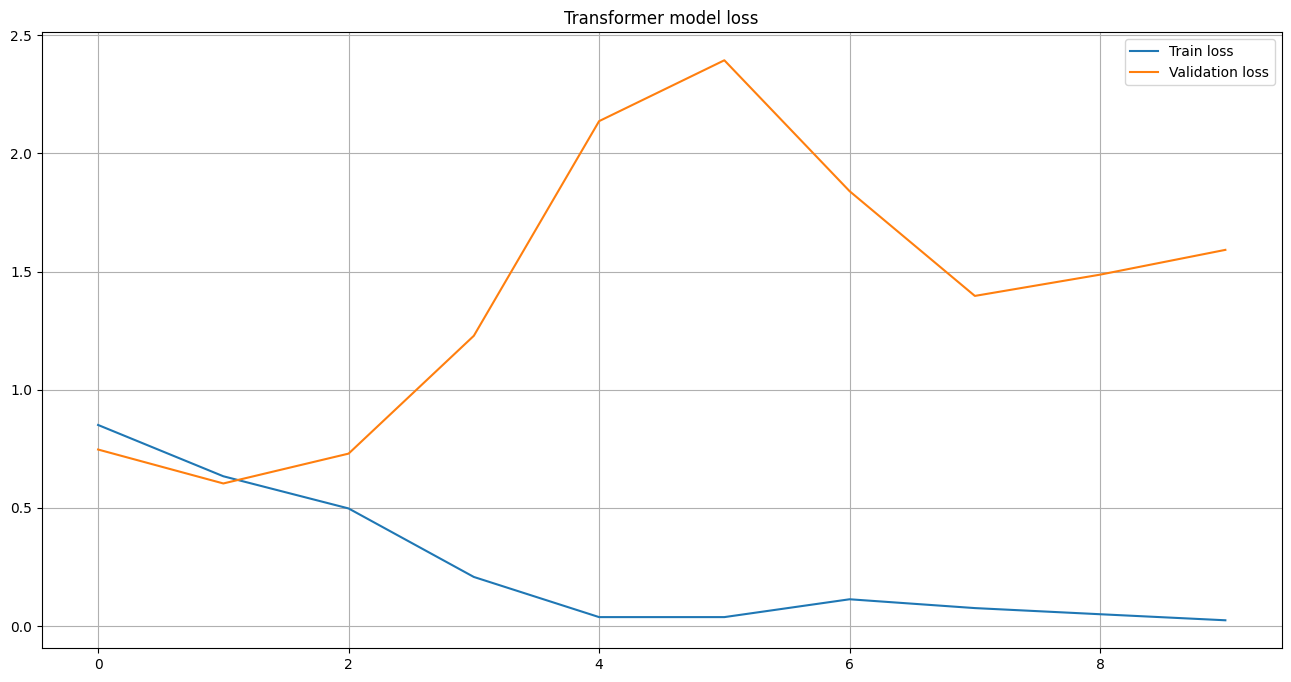

In [ ]:
accuracy_train, accuracy_test = train_and_evaluate_classifier(features_array, df_Y_array, df_group_array, num_classes=2)

Вывод: как видим модель сильно переобучилась